In [ ]:
import numpy as np
import pandas as pd
import time

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/merged_dataset.csv')
df['Date'] = pd.to_datetime(df['Date']).apply(lambda date: date.toordinal()) # Use toordinal() instead of ordinal

In [ ]:
X = df.drop(['Estimated_fire_area_', 'Region'], axis=1)
y = df['Estimated_fire_area_']

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(np.array(y).reshape(-1,1))

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

In [ ]:
start_time = time.time()

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
# Initialize and train the XGBoost regressor
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42) # Use reg:squarederror for regression
xgb_model.fit(X_train, y_train.ravel())

# Make predictions on the test set
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate the model
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
print(f"XGBoost Mean Squared Error: {mse_xgb}")
print(f"XGBoost R2 score: {r2_score(y_test, y_pred_xgb)}")
print(f"XGBoost Mean Absolute Error: {mean_absolute_error(y_test, y_pred_xgb)}")


XGBoost Mean Squared Error: 0.0001544379055802101
XGBoost R2 score: 0.7983248960235223
XGBoost Mean Absolute Error: 0.006703255373202798


In [ ]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np

# Load data
data = pd.read_csv('/content/drive/MyDrive/weather_pivoted.csv')

data = data[data['Estimated_fire_area_'] <= 1000]

# Convert 'Date' to datetime format
data['Date_'] = pd.to_datetime(data['Date_'], format='%d/%m/%Y', errors='coerce')  # Handle potential errors in date format

# Extract numerical features for scaling
numerical_features = data.select_dtypes(include=['number']).columns
numerical_data = data[numerical_features]

# Handle NaN values in the entire DataFrame before scaling
numerical_data = numerical_data.fillna(numerical_data.mean())  # Replace NaNs with column means

# Normalize the numerical data
scaler = MinMaxScaler()
scaled_numerical_data = scaler.fit_transform(numerical_data)

# Convert scaled numerical data back to DataFrame
scaled_numerical_data = pd.DataFrame(scaled_numerical_data, columns=numerical_features, index=data.index)

# Concatenate scaled numerical data with original date column
scaled_data_lstm = pd.concat([data['Date_'], scaled_numerical_data], axis=1)
# Prepare data for LSTM
target_column = 'Estimated_fire_area_'
X_lstm = scaled_data_lstm.drop(columns=['Date_', target_column])
y_lstm = scaled_data_lstm[target_column]

# Split data into training and testing sets
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_lstm, y_lstm, test_size=0.2, random_state=42)

# Reshape data for LSTM input
X_train_lstm = X_train_lstm.values.reshape((X_train_lstm.shape[0], 1, X_train_lstm.shape[1]))
X_test_lstm = X_test_lstm.values.reshape((X_test_lstm.shape[0], 1, X_test_lstm.shape[1]))

# Check for and handle NaN/infinite values in X_train and y_train (optional, but good practice)
X_train_lstm = np.nan_to_num(X_train_lstm, nan=np.nanmean(X_train_lstm))
y_train_lstm = np.nan_to_num(y_train_lstm, nan=np.nanmean(y_train_lstm))

# Define LSTM model with 'tanh' activation and gradient clipping
model = Sequential()
model.add(LSTM(50, activation='tanh', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]), recurrent_dropout=0.2))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer=tf.keras.optimizers.Adam(clipvalue=1.0), loss='mse')  # Clip gradients

# Train the model
model.fit(X_train_lstm, y_train_lstm, epochs=10, batch_size=32, validation_split=0.1, verbose=1)

# Evaluate the model
loss = model.evaluate(X_test_lstm, y_test_lstm.values, verbose=0)  # Convert y_test to NumPy array
print(f'Test Loss: {loss}')

# Make predictions
y_pred_lstm = model.predict(X_test_lstm)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
586/586 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.0247 - val_loss: 0.0183
Epoch 2/10
586/586 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0199 - val_loss: 0.0169
Epoch 3/10
586/586 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0190 - val_loss: 0.0168
Epoch 4/10
586/586 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0194 - val_loss: 0.0168
Epoch 5/10
586/586 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0188 - val_loss: 0.0164
Epoch 6/10
586/586 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0187 - val_loss: 0.0163
Epoch 7/10
586/586 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0184 - val_loss: 0.0162
Epoch 8/10
586/586 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0187 - val_loss: 0.0166
Epoch 9/10
586/586 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0185 - val_loss: 0.0167
Epoch 10/10
586/586 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0178 - val_loss: 0.0160
Test Loss: 0.01830393448472023
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


In [ ]:
# Assuming y_pred_xgb has extra rows, adjust to match y_pred_lstm's size
ensemble_input = np.column_stack((y_pred_lstm.ravel(), y_pred_xgb[:len(y_pred_lstm)]))

# Train a meta-learner (Linear Regression) - you need to import this first
from sklearn.linear_model import LinearRegression # Import LinearRegression
meta_model = LinearRegression()
meta_model.fit(ensemble_input, y_test[:len(y_pred_lstm)]) # Adjust y_test size as well

# Final ensemble prediction
y_pred_ensemble = meta_model.predict(ensemble_input)

# Evaluate performance
mse_ensemble = mean_squared_error(y_test[:len(y_pred_lstm)], y_pred_ensemble) # Adjust y_test size for evaluation
r2_ensemble = r2_score(y_test[:len(y_pred_lstm)], y_pred_ensemble) # Adjust y_test size for evaluation
mae_ensemble = mean_absolute_error(y_test[:len(y_pred_lstm)], y_pred_ensemble) # Adjust y_test size for evaluation

print(f"Ensemble Mean Squared Error: {mse_ensemble}")
print(f"Ensemble R2 score: {r2_ensemble}")
print(f"Ensemble Mean Absolute Error: {mae_ensemble}")

Ensemble Mean Squared Error: 0.00014224389103562456
Ensemble R2 score: 0.7858696706268997
Ensemble Mean Absolute Error: 0.0066280041930338145


In [ ]:
end_time = time.time()
ensemble_elapsed_time = end_time - start_time

print(f"Model training took {ensemble_elapsed_time:.2f} seconds.")

Model training took 66.96 seconds.


In [ ]:
rf_start_time = time.time()

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)  # You can adjust n_estimators
rf_model.fit(X_train, y_train.ravel())

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_score_rf = r2_score(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)

print(f"Random Forest Mean Squared Error: {mse_rf}")
print(f"Random Forest R2 score: {r2_score_rf}")
print(f"Random Forest Mean Absolute Error: {mae_rf}")
print(f"Random Forest Root Mean Squared Error: {rmse_rf}")



Random Forest Mean Squared Error: 0.00010738942326639266
Random Forest R2 score: 0.8597638771268148
Random Forest Mean Absolute Error: 0.004471118158832034
Random Forest Root Mean Squared Error: 0.010362886821074167


In [ ]:
rf_end_time = time.time()
rf_elapsed_time = rf_end_time - rf_start_time

print(f"Model training took {rf_elapsed_time:.2f} seconds.")

Model training took 361.82 seconds.


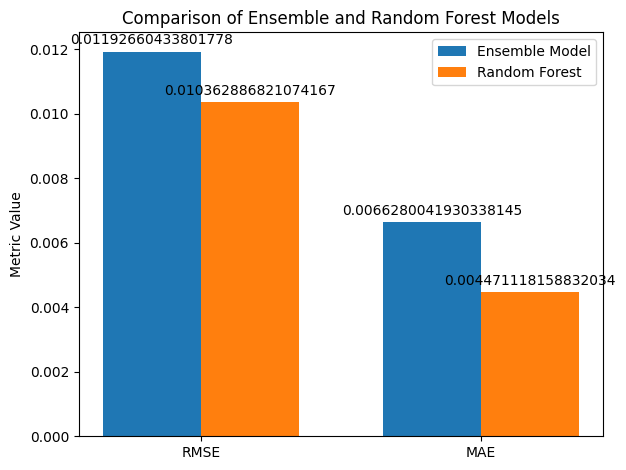

In [ ]:
import matplotlib.pyplot as plt
rmse_ensemble = np.sqrt(mse_ensemble)
# Data for the plot (replace with your actual values)
metrics = ['RMSE', 'MAE']
ensemble_values = [rmse_ensemble,mae_ensemble]
rf_values = [rmse_rf, mae_rf]

x = np.arange(len(metrics))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, ensemble_values, width, label='Ensemble Model')
rects2 = ax.bar(x + width/2, rf_values, width, label='Random Forest')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Metric Value')
ax.set_title('Comparison of Ensemble and Random Forest Models')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Add value labels above each bar
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()


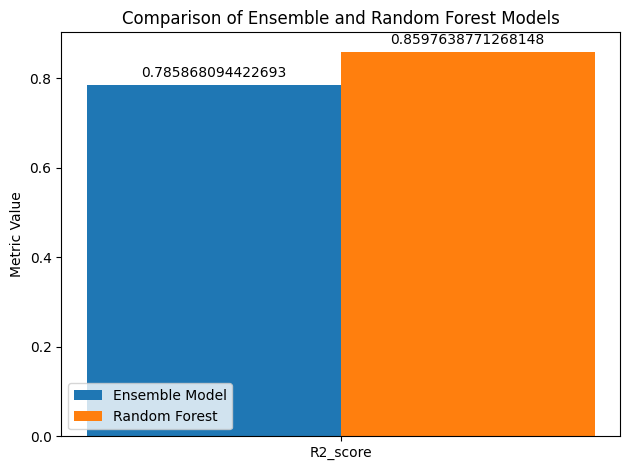

In [ ]:
import matplotlib.pyplot as plt

# Data for the plot (replace with your actual values)
metrics = ['R2_score']
ensemble_values = [r2_ensemble]
rf_values = [r2_score_rf]

x = np.arange(len(metrics))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, ensemble_values, width, label='Ensemble Model')
rects2 = ax.bar(x + width/2, rf_values, width, label='Random Forest')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Metric Value')
ax.set_title('Comparison of Ensemble and Random Forest Models')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Add value labels above each bar
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()

In [ ]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

X_train_df = pd.DataFrame(X_train)  # Convert to DataFrame for imputation
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train_df)

# Now use X_train_imputed for training your SVR model
svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.2)  # You can adjust kernel, C, and epsilon
svr_model.fit(X_train_imputed, y_train.ravel())

# Impute X_test using the same imputer fitted on X_train
X_test_df = pd.DataFrame(X_test)
X_test_imputed = imputer.transform(X_test_df) # Impute X_test

# Make predictions on the imputed test set
y_pred_svr = svr_model.predict(X_test_imputed)

# Evaluate the model
mse_svr = mean_squared_error(y_test, y_pred_svr)
r2_score_svr = r2_score(y_test, y_pred_svr)
mae_svr = mean_absolute_error(y_test, y_pred_svr)
rmse_svr = np.sqrt(mse_svr)

print(f"SVR Mean Squared Error: {mse_svr}")
print(f"SVR R2 score: {r2_score_svr}")
print(f"SVR Mean Absolute Error: {mae_svr}")
print(f"SVR Root Mean Squared Error: {rmse_svr}")

SVR Mean Squared Error: 0.014641068149962959
SVR R2 score: -18.11926304864914
SVR Mean Absolute Error: 0.1160499771347686
SVR Root Mean Squared Error: 0.12100028161108949


In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.impute import SimpleImputer # Import SimpleImputer

nb_model = GaussianNB()
y_train_discrete = np.where(y_train.ravel() > 0.5, 1, 0) # Convert to binary classes (0 or 1)

# Impute missing values in X_train
imputer = SimpleImputer(strategy='mean')  # Replace NaNs with the mean of each column
X_train_imputed = imputer.fit_transform(X_train)

nb_model.fit(X_train_imputed, y_train_discrete) # Fit with discrete labels and imputed data

# Impute missing values in X_test using the same imputer fitted on X_train
X_test_imputed = imputer.transform(X_test)  # Impute missing values in X_test
y_pred_nb = nb_model.predict(X_test_imputed) # Use imputed X_test for prediction

# Evaluate the model
mse_nb = mean_squared_error(y_test, y_pred_nb)
r2_score_nb = r2_score(y_test, y_pred_nb)
mae_nb = mean_absolute_error(y_test, y_pred_nb)
rmse_nb = np.sqrt(mse_nb)

print(f"Naive Bayes Mean Squared Error: {mse_nb}")
print(f"Naive Bayes R2 score: {r2_score_nb}")
print(f"Naive Bayes Mean Absolute Error: {mae_nb}")
print(f"Naive Bayes Root Mean Squared Error: {rmse_nb}")

Naive Bayes Mean Squared Error: 0.1502902053349221
Naive Bayes R2 score: -195.2587660956375
Naive Bayes Mean Absolute Error: 0.16291844593334717
Naive Bayes Root Mean Squared Error: 0.38767280706147306


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

# Define TCN model
tcn_model = Sequential()
tcn_model.add(Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]))) # Changed kernel_size to 1
tcn_model.add(MaxPooling1D(pool_size=1)) # Changed pool_size to 1
tcn_model.add(Conv1D(filters=128, kernel_size=1, activation='relu')) # Changed kernel_size to 1
tcn_model.add(MaxPooling1D(pool_size=1)) # Changed pool_size to 1
tcn_model.add(Flatten())
tcn_model.add(Dense(1))
tcn_model.compile(optimizer='adam', loss='mse')

# Train the model
tcn_model.fit(X_train_lstm, y_train_lstm, epochs=10, batch_size=32, validation_split=0.1, verbose=1)

# Evaluate the model
loss_tcn = tcn_model.evaluate(X_test_lstm, y_test_lstm.values, verbose=0)
print(f'TCN Test Loss: {loss_tcn}')

# Make predictions
y_pred_tcn = tcn_model.predict(X_test_lstm)

mse_tcn = mean_squared_error(y_test_lstm, y_pred_tcn)
r2_tcn = r2_score(y_test_lstm, y_pred_tcn)
mae_tcn = mean_absolute_error(y_test_lstm, y_pred_tcn)
rmse_tcn = np.sqrt(mse_tcn)
print(f"TCN Mean Squared Error: {mse_tcn}")
print(f"TCN R2 score: {r2_tcn}")
print(f"TCN Mean Absolute Error: {mae_tcn}")
print(f"TCN Root Mean Squared Error: {rmse_tcn}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
586/586 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0222 - val_loss: 0.0168
Epoch 2/10
586/586 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0180 - val_loss: 0.0166
Epoch 3/10
586/586 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0177 - val_loss: 0.0157
Epoch 4/10
586/586 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0166 - val_loss: 0.0154
Epoch 5/10
586/586 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0170 - val_loss: 0.0153
Epoch 6/10
586/586 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0175 - val_loss: 0.0150
Epoch 7/10
586/586 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0162 - val_loss: 0.0154
Epoch 8/10
586/586 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0160 - val_loss: 0.0149
Epoch 9/10
586/586 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0157 - val_loss: 0.0146
Epoch 10/10
586/586 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0150 - val_loss: 0.0150
TCN Test Loss: 0.017643557861447334
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
TCN Mean Squared Error: 0.01764355505834468
TCN R2 score: 0.38

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# For demonstration, let's use (5, 1, 0)
model = ARIMA(y_train_lstm, order=(5, 1, 0))

# Fit the model to your data
model_fit = model.fit()

# Make predictions on the test set
y_pred_arima = model_fit.predict(start=len(y_train_lstm), end=len(y_train_lstm) + len(y_test_lstm) - 1)

# Evaluate the model
mse_arima = mean_squared_error(y_test_lstm, y_pred_arima)
mae_arima = mean_absolute_error(y_test_lstm, y_pred_arima)
rmse_arima = np.sqrt(mse_arima)  # Calculate RMSE
r2_arima = r2_score(y_test_lstm, y_pred_arima)

print(f"ARIMA Mean Squared Error: {mse_arima}")
print(f"ARIMA Mean Absolute Error: {mae_arima}")
print(f"ARIMA Root Mean Squared Error: {rmse_arima}")
print(f"ARIMA R-squared: {r2_arima}")

ARIMA Mean Squared Error: 0.031948355123771754
ARIMA Mean Absolute Error: 0.10044186145194879
ARIMA Root Mean Squared Error: 0.1787410280930815
ARIMA R-squared: -0.10470080202146836


<ipython-input-36-0803f2f096ce>:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(models, rotation=45, ha="right")  # Rotate x-axis labels
<ipython-input-36-0803f2f096ce>:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(models, rotation=45, ha="right")  # Rotate x-axis labels
<ipython-input-36-0803f2f096ce>:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[2].set_xticklabels(models, rotation=45, ha="right")  # Rotate x-axis labels


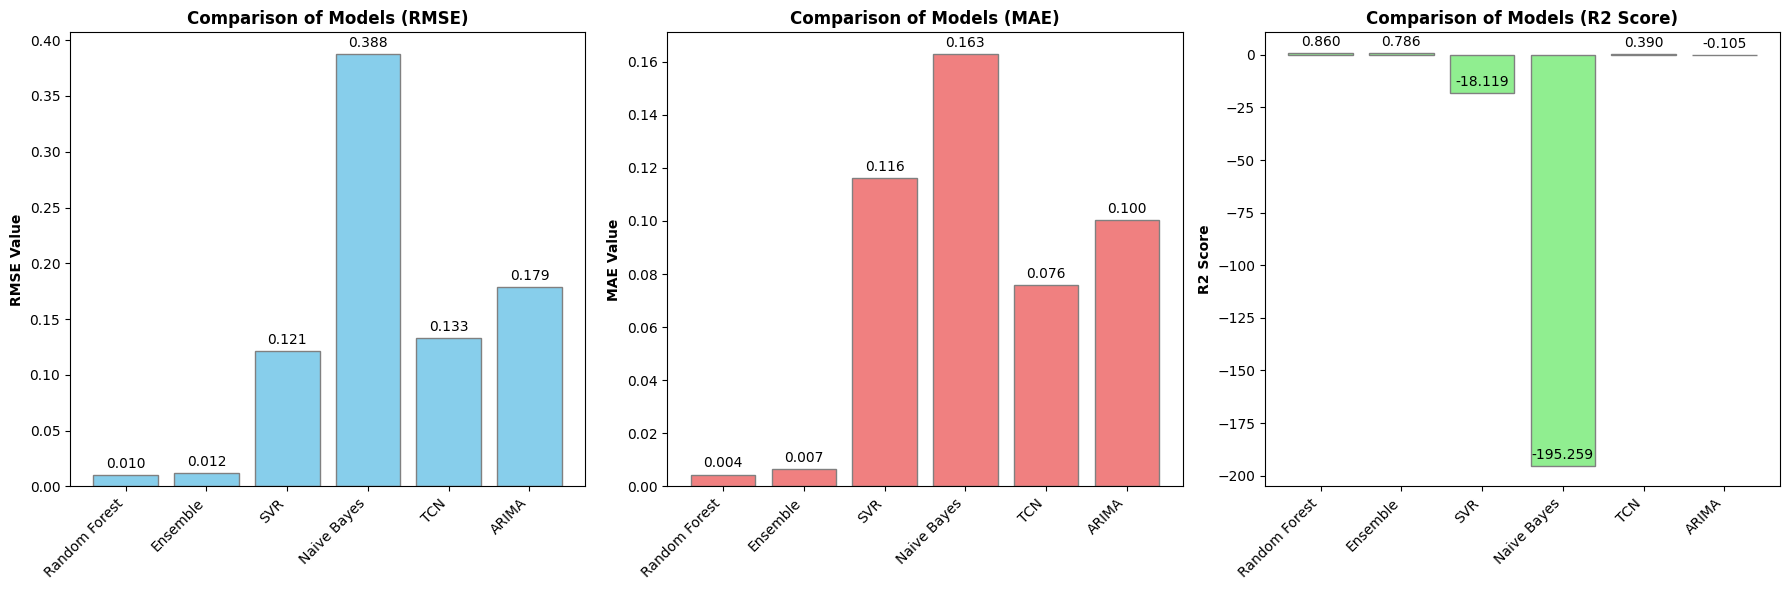

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data for the plot
models = ['Random Forest', 'Ensemble', 'SVR', 'Naive Bayes', 'TCN', 'ARIMA']
rmse_values = [rmse_rf, np.sqrt(mse_ensemble), rmse_svr, rmse_nb, rmse_tcn, rmse_arima]
mae_values = [mae_rf, mae_ensemble, mae_svr, mae_nb, mae_tcn, mae_arima]
r2_values = [r2_score_rf, r2_ensemble, r2_score_svr, r2_score_nb, r2_tcn, r2_arima]

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns

# RMSE plot
axs[0].bar(models, rmse_values, color='skyblue', edgecolor='grey')
axs[0].set_ylabel('RMSE Value', fontweight='bold')
axs[0].set_title('Comparison of Models (RMSE)', fontweight='bold')
axs[0].set_xticklabels(models, rotation=45, ha="right")  # Rotate x-axis labels

# MAE plot
axs[1].bar(models, mae_values, color='lightcoral', edgecolor='grey')
axs[1].set_ylabel('MAE Value', fontweight='bold')
axs[1].set_title('Comparison of Models (MAE)', fontweight='bold')
axs[1].set_xticklabels(models, rotation=45, ha="right")  # Rotate x-axis labels

# R2 score plot
axs[2].bar(models, r2_values, color='lightgreen', edgecolor='grey')
axs[2].set_ylabel('R2 Score', fontweight='bold')
axs[2].set_title('Comparison of Models (R2 Score)', fontweight='bold')
axs[2].set_xticklabels(models, rotation=45, ha="right")  # Rotate x-axis labels

# Add value labels above each bar for all subplots
def autolabel(rects, ax):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',  # Format with 2 decimal places
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(axs[0].patches, axs[0])
autolabel(axs[1].patches, axs[1])
autolabel(axs[2].patches, axs[2])

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

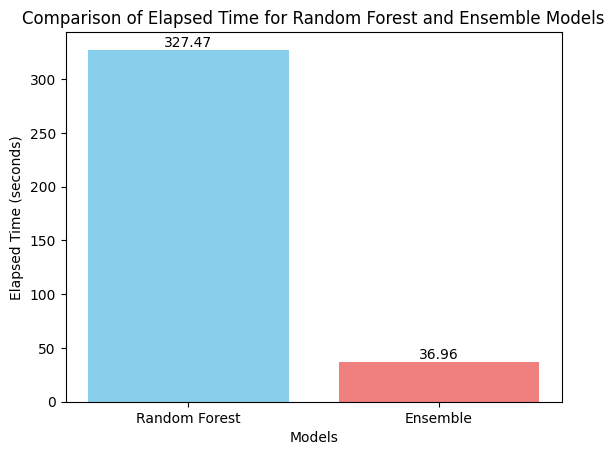

In [ ]:
import matplotlib.pyplot as plt

# Data for the plot
models = ['Random Forest', 'Ensemble']
elapsed_times = [rf_elapsed_time, ensemble_elapsed_time]

# Create the bar plot
plt.bar(models, elapsed_times, color=['skyblue', 'lightcoral'])
plt.xlabel("Models")
plt.ylabel("Elapsed Time (seconds)")
plt.title("Comparison of Elapsed Time for Random Forest and Ensemble Models")

# Add labels above each bar
for i, v in enumerate(elapsed_times):
    plt.text(i, v, str(round(v, 2)), ha='center', va='bottom')

plt.show()